# < 영화 추천 시스템 만들기 >

**- 목차 -**

□ Step1 데이터 준비와 전처리   
□ Step2 데이터 분석
□ Step3 내가 선호하는 영화를 5가지 골라서 ratings에 추가  
□ Step4 CSR(Compressed Spares Row) matrix 만들기   
□ Step5 AlternatingLeastSquares 모델 구성 및 훈련  
□ Step6 나의 선호도 파악   
□ Step7 내가 좋아하는 영화와 비슷한 영화 추천 받기   
□ Step8 내가 가장 좋아할 만한 영화 추천 받기   
□ 정리 및 회고

### ■ Step1 데이터 준비와 전처리

**1-1 필요한 라이브러리 import**

In [2]:
import os
import pandas as pd
import numpy as np

**1-2 데이터 준비**

- 활용할 데이터셋은 추천시스템의 MNIST라고 부를만한 **['Movielens'](https://grouplens.org/datasets/movielens/)** 데이터
- 유저가 영화에 대해 평점을 매긴 데이터가 데이터 크기 별로 있음
- ['MovieLens 1M Dataset'](https://grouplens.org/datasets/movielens/1m/)을 사용
- 'MovieLens 1M 데이터셋'에는 4000개의 영화에 대한 6000명의 평가가 1백만 개 있음(Released 2/2003)
- Movielens 데이터는 `rating.dat` 안에 이미 인덱싱까지 완료된 사용자-영화-평점 데이터가 깔끔하게 정리되어 있음
- 별점 데이터는 대표적인 explicit(명시적) 데이터 이지만, implicit(암묵적) 데이터로 간주하고 테스트해볼 수 있음
- 별점을 시청횟수로 해석하여 활용
- 유저가 3점 미만으로 준 데이터는 선호하지 않는다고 가정하고 제외

In [10]:
rating_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'ratings', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding = "ISO-8859-1")
orginal_data_size = len(ratings)
ratings.head()

,user_id,movie_id,ratings,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


**1-3 평점 3점 이상만 남기기**

In [11]:
ratings = ratings[ratings['ratings']>=3]
filtered_data_size = len(ratings)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


- 1백만개의 평가 중 3점 이상의 평점은 83.63%로, 이제 836478개의 데이터로 추천시스템을 만들 것임

**1-4 ratings 컬럼의 이름을 counts로 바꾸기**

In [12]:
ratings.rename(columns={'ratings':'counts'}, inplace=True)

In [13]:
ratings['counts']

0          5
1          3
2          3
3          4
4          5
          ..
1000203    3
1000205    5
1000206    5
1000207    4
1000208    4
Name: counts, Length: 836478, dtype: int64

**1-5 영화 제목을 보기 위해 메타 데이터를 읽어오기**

In [14]:
movie_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


**1-6 ratings와 movies 데이터 프레임 합치기**

In [15]:
data = ratings.join(movies.set_index('movie_id'), on='movie_id')
data.head()

,user_id,movie_id,counts,timestamp,title,genre
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,661,3,978302109,James and the Giant Peach (1996),Animation|Children's|Musical
2,1,914,3,978301968,My Fair Lady (1964),Musical|Romance
3,1,3408,4,978300275,Erin Brockovich (2000),Drama
4,1,2355,5,978824291,"Bug's Life, A (1998)",Animation|Children's|Comedy


In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 836483 entries, 0 to 836482
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   user_id   836483 non-null  int64
 1   movie_id  836483 non-null  int64
 2   counts    836483 non-null  int64
 3   title     836483 non-null  int64
dtypes: int64(4)
memory usage: 25.5 MB


### ■ Step2 데이터 분석

**2-1 ratings에 있는 유니크한 영화 개수**

In [16]:
data['movie_id'].nunique()

3628

**2-2 ratings에 있는 유니크한 사용자 수**

In [17]:
data['user_id'].nunique()

6039

**2-3 가장 인기 있는 영화 30개(인기순)**

In [18]:
movie_count = data.groupby('title')['user_id'].count()
movie_count.sort_values(ascending=False).head(30)

title
American Beauty (1999)                                   3211
Star Wars: Episode IV - A New Hope (1977)                2910
Star Wars: Episode V - The Empire Strikes Back (1980)    2885
Star Wars: Episode VI - Return of the Jedi (1983)        2716
Saving Private Ryan (1998)                               2561
Terminator 2: Judgment Day (1991)                        2509
Silence of the Lambs, The (1991)                         2498
Raiders of the Lost Ark (1981)                           2473
Back to the Future (1985)                                2460
Matrix, The (1999)                                       2434
Jurassic Park (1993)                                     2413
Sixth Sense, The (1999)                                  2385
Fargo (1996)                                             2371
Braveheart (1995)                                        2314
Men in Black (1997)                                      2297
Schindler's List (1993)                                  2257
Pr

**2-4 유저 별, 영화 별 통계 확인**

In [19]:
# 유저 별 몇 편의 영화를 시청했는지에 대한 통계

user_count = data.groupby('user_id')['movie_id'].count()
user_count.describe()

count    6039.000000
mean      138.512668
std       156.241599
min         1.000000
25%        38.000000
50%        81.000000
75%       177.000000
max      1968.000000
Name: movie_id, dtype: float64

In [20]:
# 영화 별 시청(counts)횟수 중앙값에 대한 통계

user_median = data.groupby('user_id')['counts'].median()
user_median.describe()

count    6039.000000
mean        4.055970
std         0.432143
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: counts, dtype: float64

 ### ■ Step3 내가 선호하는 영화를 5가지 골라서 ratings에 추가

**3-1 영화 제목으로 검색하여 my_favorite_movie_id 리스트 생성**

In [22]:
movies[movies['title'].str.lower().str.contains('matrix', regex=False)]

,movie_id,title,genre
2502,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller


In [23]:
my_favorite_movie_id = [1, 356, 1580, 1907, 2571]

**3-2 my_favorite_movie_id 리스트를 my_favorite_movie_title 리스트로 변환**

In [24]:
my_favorite_movie_title = []
for i in my_favorite_movie_id:
    my_favorite_movie_title.append(list(movies[movies['movie_id']==i]['title'])[0])
    
print(my_favorite_movie_title)

['Toy Story (1995)', 'Forrest Gump (1994)', 'Men in Black (1997)', 'Mulan (1998)', 'Matrix, The (1999)']


**3-3 my_movielist 데이터 프레임 생성**

In [25]:
#'gwangmin'이라는 user_id가 위 영화들을 5회씩 봤다고 가정

my_movielist = pd.DataFrame({'user_id': ['gwangmin']*5,
                            'movie_id': my_favorite_movie_id,
                            'counts':[5]*5,
                            'title':my_favorite_movie_title})
my_movielist

,user_id,movie_id,counts,title
0,gwangmin,1,5,Toy Story (1995)
1,gwangmin,356,5,Forrest Gump (1994)
2,gwangmin,1580,5,Men in Black (1997)
3,gwangmin,1907,5,Mulan (1998)
4,gwangmin,2571,5,"Matrix, The (1999)"


**3-4 전체 데이터프레임에 my_movielist 데이터프레임 추가**

In [26]:
if not data.isin({'user_id':['gwangmin']})['user_id'].any():  # user_id에 'gwangmin'이라는 데이터가 없다면
    data = data.append(my_movielist, ignore_index=True)  # 위에 임의로 만든 my_movielist 데이터를 추가 

data = data[['user_id', 'movie_id', 'counts', 'title']]
data.tail(10)

,user_id,movie_id,counts,title
836473,6040,1090,3,Platoon (1986)
836474,6040,1094,5,"Crying Game, The (1992)"
836475,6040,562,5,Welcome to the Dollhouse (1995)
836476,6040,1096,4,Sophie's Choice (1982)
836477,6040,1097,4,E.T. the Extra-Terrestrial (1982)
836478,gwangmin,1,5,Toy Story (1995)
836479,gwangmin,356,5,Forrest Gump (1994)
836480,gwangmin,1580,5,Men in Black (1997)
836481,gwangmin,1907,5,Mulan (1998)
836482,gwangmin,2571,5,"Matrix, The (1999)"


### ■ Step4 CSR(Compressed Spares Row) matrix 만들기

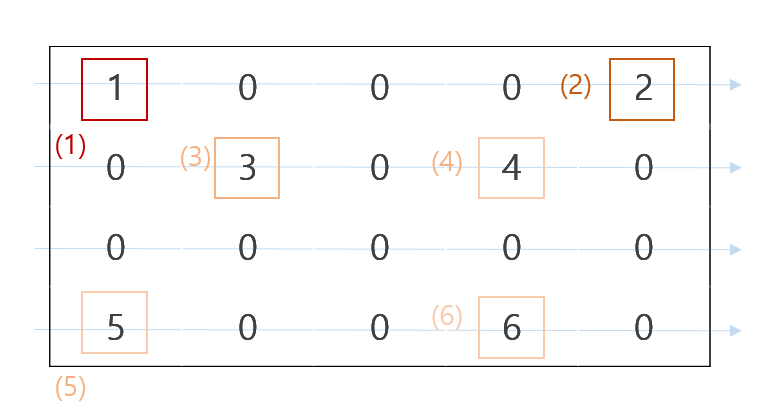
[사진 출처 및 CSR Matrix에 대한 추가 설명](https://lovit.github.io/nlp/machine%20learning/2018/04/09/sparse_mtarix_handling/#csr-matrix)

- CSR(Compressed Sparse Row) Matrix는 Sparse한 matrix에서 0이 아닌 유효한 데이터로 채워지는 데이터의 값과 좌표 정보만으로 구성하여 메모리 사용량을 최소화하면서도 Sparse한 matrix와 동일한 행렬을 표현할 수 있도록 하는 데이터 구조로, 데이터를 Row 순서대로 저장함

- CSR Matrix에는 **data**, **indices**, **indptr**가 있음

    - data는 0이 아닌 요소의 값

    - indices는 data의 값에 해당하는 column index

    - indptr는 row별 data의 begin index와 end index가 저장
    
- CSR Matrix를 만들기 위해서 데이터프레임의 user_id와 movie_id를 인덱싱하는 사전 작업을 먼저 실시

**4-1 고유한 유저와 영화를 찾기**

In [27]:
user_unique = data['user_id'].unique()
movie_unique = data['title'].unique()

**4-2 유저, 영화 indexing 하고 확인하기**

In [30]:
user_to_idx = {v:k for k,v in enumerate(user_unique)}  # idx는 index의 약자
movie_to_idx = {v:k for k,v in enumerate(movie_unique)}

print(user_to_idx['gwangmin'])    # 6040명의 유저 중 마지막에 있는 유저이니 6039가 나와야 합니다. 
print(movie_to_idx['Matrix, The (1999)'])

6039
124


**4-3 데이터 프레임의 user_id와 movie_id를 인덱싱으로 변경**

In [31]:
# indexing을 통해 데이터 컬럼 내 값을 바꾸는 코드
# user_to_idx.get을 통해 user_id 컬럼의 모든 값을 인덱싱한 Series를 구해 봅시다. 
# 혹시 정상적으로 인덱싱되지 않은 row가 있다면 인덱스가 NaN이 될 테니 dropna()로 제거합니다. 
temp_user_data = data['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_data) == len(data):   # 모든 row가 정상적으로 인덱싱되었다면
    print('user_id column indexing OK!!')
    data['user_id'] = temp_user_data   # data['user_id']을 인덱싱된 Series로 교체해 줍니다. 
else:
    print('user_id column indexing Fail!!')

# movie_to_idx을 통해 title 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
temp_movie_data = data['title'].map(movie_to_idx.get).dropna()
if len(temp_movie_data) == len(data):
    print('title column indexing OK!!')
    data['title'] = temp_movie_data
else:
    print('title column indexing Fail!!')

user_id column indexing OK!!
title column indexing OK!!


**4-4 데이터 프레임 확인**

In [32]:
data

,user_id,movie_id,counts,title
0,0,1193,5,0
1,0,661,3,1
2,0,914,3,2
3,0,3408,4,3
4,0,2355,5,4
...,...,...,...,...
836478,6039,1,5,40
836479,6039,356,5,160
836480,6039,1580,5,175
836481,6039,1907,5,34


**4-5 `CSR matrix` 생성**

In [33]:
from scipy.sparse import csr_matrix

num_user = data['user_id'].nunique()
num_movie = data['title'].nunique()

csr_data = csr_matrix((data['counts'], (data.user_id, data.title)),
                      shape = (num_user, num_movie))
csr_data

<6040x3628 sparse matrix of type '<class 'numpy.longlong'>'
	with 836483 stored elements in Compressed Sparse Row format>

In [59]:
print(csr_data.data)
print(csr_data.indices)
print(csr_data.indptr)

[5 3 3 ... 5 5 5]
[  0   1   2 ... 124 160 175]
[     0     53    169 ... 836202 836478 836483]


### ■ Step5 AlternatingLeastSquares 모델 구성 및 훈련

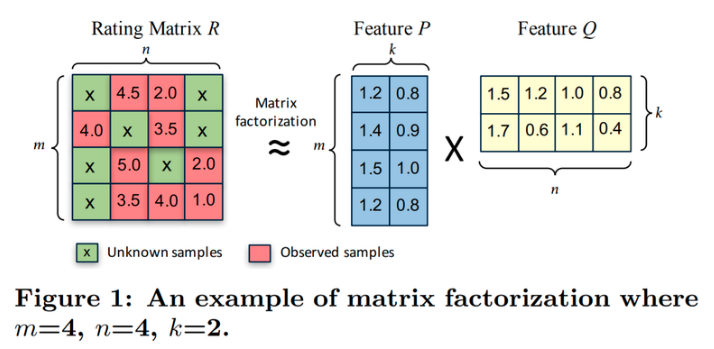

[사진출처 및 Matrix Factorization에 대한 추가설명](https://arxiv.org/pdf/1610.05838.pdf)

- Step4에서 만든 CSR Matrix를 `implicit` 패키지의 **Matrix Factorization** 모델로 학습

- `implicit` 패키지는 암묵적(implicit) dataset을 사용하는 다양한 모델을 굉장히 빠르게 학습할 수 있는 패키지

- `implicit` 패키지에 구현된 **Matrix Factorization** 모델인**`als(AlternatingLeastSquares) 모델`**을 사용

- **Matrix Factorization**에서 쪼개진 두 Feature Matrix를 한꺼번에 훈련하는 것은 잘 수렴하지 않기 때문에, 한쪽을 고정시키고 다른 쪽을 학습하는 방식을 번갈아 수행하는 **AlternatingLeastSquares** 방식이 효과적인 것으로 알려져 있음

**5-1 `implicit` 라이브러리에서 권장사항 수행(학습 내용과 무관)**

In [34]:
from implicit.als import AlternatingLeastSquares

os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

**5-2 AlternatingLeastSquares 모델 __init__ 파라미터 확인**

In [61]:
AlternatingLeastSquares.__init__

<function implicit.als.AlternatingLeastSquares.__init__(self, factors=100, regularization=0.01, dtype=<class 'numpy.float32'>, use_native=True, use_cg=True, use_gpu=False, iterations=15, calculate_training_loss=False, num_threads=0, random_state=None)>

- 1. factors : 유저(user_id)와 아이템(movie_id)의 벡터의 차원
- 2. regularization : 과적합 방지를 위한 정규화 정도
- 3. use_gpu : GPU 사용 유무
- 4. iterations : 학습 반복 횟수

**5-3 `AlternatingLeastSquares` 모델 선언**

In [35]:
als_model = AlternatingLeastSquares(factors=100, 
                                    regularization=0.01, 
                                    use_gpu=False, 
                                    iterations=15, 
                                    dtype=np.float32)

**5-3 `CSR matrix` Transpose**

In [36]:
# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해야함)

csr_data_transpose = csr_data.T
csr_data_transpose

<3628x6040 sparse matrix of type '<class 'numpy.longlong'>'
	with 836483 stored elements in Compressed Sparse Column format>

**5-4 모델 훈련**

In [37]:
# 모델 훈련
als_model.fit(csr_data_transpose)

  0%|          | 0/15 [00:00<?, ?it/s]

### ■ Step6 나의 선호도 파악

- 내가 선호하는 5가지 영화 중 하나와 그 외의 영화 하나를 골라 훈련된 모델이 예측한 나의 선호도를 파악해 보세요.

**6-1 gwangmin**(본인) **벡터, matrix**(좋아하는 영화 5개 중 1개) **벡터 확인**

In [38]:
gwangmin, matrix = user_to_idx['gwangmin'], movie_to_idx['Matrix, The (1999)']
gwangmin_vector, matrix_vector = als_model.user_factors[gwangmin], als_model.item_factors[matrix]

In [39]:
gwangmin_vector

array([ 0.9365212 , -0.23317707, -0.40296915, -0.6283487 , -0.50868237,
        0.8320377 ,  1.0792793 , -0.04017761,  0.22043474,  0.5467907 ,
        0.20199348,  0.7102251 ,  0.31508476,  0.11749194,  0.11632191,
        0.7106335 , -1.312226  ,  0.03066934,  0.02384569, -0.07566502,
       -0.26928508,  0.01525835,  0.4252651 , -0.45730457,  0.1770558 ,
        0.20796719,  0.48980045, -0.01189139,  0.19702129, -0.76660883,
        0.36043876, -0.18404983, -0.14660865,  0.00873526,  0.01061968,
       -0.83973986,  0.03690937,  1.1111146 , -1.0315634 , -0.42019868,
        0.6327859 , -0.08975108, -0.11546391,  0.02235164, -0.1052355 ,
        0.13347179,  0.22807626,  0.48533845,  0.19469771, -0.50147516,
       -0.35857517,  0.7253157 ,  0.03043796, -0.82414407, -0.5248196 ,
        0.7507935 ,  0.756134  ,  0.13529003,  0.29975772, -0.17120871,
       -0.37592202,  0.6116026 ,  0.16911514, -0.2950315 , -0.8511801 ,
        0.06130696,  0.3242942 , -0.09232081,  0.4451765 , -0.57

In [40]:
matrix_vector

array([ 3.46680731e-02,  3.00639542e-03,  1.77235603e-02, -2.41113380e-02,
       -8.73871613e-03, -5.58390049e-03,  2.85550784e-02,  8.22111964e-03,
        9.18979477e-03,  5.10399090e-03,  1.40918419e-02,  2.63254587e-02,
       -5.25658764e-03,  2.08660457e-02, -1.81176432e-03,  1.00587681e-02,
       -1.13676889e-02,  2.10518893e-02, -1.06759900e-02, -2.04001833e-03,
       -1.09180948e-02, -2.65146978e-03,  1.55633567e-02,  2.27765669e-03,
        1.73916742e-02,  9.18161822e-05,  4.15203981e-02,  2.82512121e-02,
        3.80719802e-03, -1.66315604e-02,  3.45701730e-04,  3.08470964e-03,
       -1.11768665e-02,  2.26840377e-03, -2.08225977e-02, -5.46675222e-03,
        8.84780195e-03,  3.90706882e-02, -3.82668599e-02,  1.82299863e-03,
        2.73941923e-02, -1.88252740e-02, -2.42250692e-03,  6.25435403e-03,
        2.82504335e-02, -1.71129704e-02,  1.37414187e-02,  1.55638475e-02,
        3.95340798e-03,  9.06278752e-03,  1.29274344e-02,  2.34987549e-02,
        2.68239379e-02,  

**6-2 gwangmin과 matrix 내적(곱하기)**

In [41]:
np.dot(gwangmin_vector, matrix_vector)

0.5099555

- 내가 직접 입력한 영화이기에 내적 값이 1이 나와야 될 것 같은데 한참 낮은 수치가 나옴

**6-3 다른 영화(Antz)에 대한 선호도는 어떻게 예측할지 확인**

In [42]:
antz = movie_to_idx['Antz (1998)']
antz_vector = als_model.item_factors[antz]
np.dot(gwangmin_vector, antz_vector)

0.17337522

- 상당히 낮은 값이 나옴.
- 벡터 내적 값이 얼마 이상이여야지 선호하는 영화라고 판단다는 기준은 모델을 만드는 사람이 정하기 나름이라고 함. 객관적인 지표로 만들어서 기준을 정할 수도 있고, 도메인 경험을 통해 정할 수도 있다고 함.
- 이처럼 추천 시스템은 사람(개인)에 대해 정확히 파악할 수 없기 때문에 객관적인 지표를 정하기 어렵고, 따라서 다른 머신러닝 작업보다 객관적인 평가가 어려운 분야임.

**6-4 als 모델 factors=200으로 하이퍼파라미터 튜닝**

In [63]:
# 모델 선언
als_model2 = AlternatingLeastSquares(factors=200, 
                                     regularization=0.01, 
                                     use_gpu=False, 
                                     iterations=15, 
                                     dtype=np.float32)

# 모델 학습
als_model2.fit(csr_data_transpose)

# 벡터값 변수에 저장
gwangmin, matrix = user_to_idx['gwangmin'], movie_to_idx['Matrix, The (1999)']
gwangmin_vector = als_model2.user_factors[gwangmin]
matrix_vector = als_model2.item_factors[matrix]

# 유저와 영화 내적
np.dot(gwangmin_vector, matrix_vector)

  0%|          | 0/15 [00:00<?, ?it/s]

0.7116942

**6-5 als 모델 factors=200, iterations=30으로 하이퍼파라미터 튜닝**

In [66]:
# 모델 선언
als_model3 = AlternatingLeastSquares(factors=200, 
                                     regularization=0.01, 
                                     use_gpu=False, 
                                     iterations=30, 
                                     dtype=np.float32)

# 모델 학습
als_model3.fit(csr_data_transpose)

# 벡터값 변수에 저장
gwangmin, matrix = user_to_idx['gwangmin'], movie_to_idx['Matrix, The (1999)']
gwangmin_vector = als_model3.user_factors[gwangmin]
matrix_vector = als_model3.item_factors[matrix]

# 유저와 영화 내적
np.dot(gwangmin_vector, matrix_vector)

  0%|          | 0/30 [00:00<?, ?it/s]

0.7178756

- 하이퍼파리미터 중 벡터 차원의 값을 결정하는 factors를 100에서 200으로 바꾸어 모델을 학습시키니, 유저와 영화의 내적 값이 0.5에서 0.71로 상당히 향상되음.

- iterations을 15에서 30으로 바꾸어 진행하였으나 더 이상의 향상은 나타나지 않음.

- 하지만 0.71이라는 값도 1하고는 아직 상당한 거리가 있음..

### ■ Step7 내가 좋아하는 영화와 비슷한 영화 추천 받기

**7-1 `similar_items` 메서드로 내가 좋아하는 영화와 비슷한 영화 찾기**

In [43]:
favorite_movie = 'Toy Story (1995)'
movie_id = movie_to_idx[favorite_movie]
similar_movie = als_model.similar_items(movie_id, N=15)
similar_movie

[(40, 1.0000001),
 (50, 0.7790652),
 (33, 0.58271897),
 (4, 0.5521627),
 (322, 0.5499463),
 (110, 0.5065156),
 (330, 0.46842682),
 (10, 0.44906643),
 (20, 0.42620668),
 (255, 0.42289424),
 (160, 0.37899724),
 (126, 0.33953798),
 (34, 0.33586186),
 (32, 0.33352444),
 (458, 0.33212608)]

**7-2 movie_id를 title로 변환**

In [44]:
#movie_to_idx 를 뒤집어, index로부터 movie 이름을 얻는 dict를 생성

idx_to_movie = {v:k for k,v in movie_to_idx.items()}
[idx_to_movie[i[0]] for i in similar_movie]

['Toy Story (1995)',
 'Toy Story 2 (1999)',
 'Aladdin (1992)',
 "Bug's Life, A (1998)",
 'Babe (1995)',
 'Groundhog Day (1993)',
 'Lion King, The (1994)',
 'Beauty and the Beast (1991)',
 'Pleasantville (1998)',
 "There's Something About Mary (1998)",
 'Forrest Gump (1994)',
 'Shakespeare in Love (1998)',
 'Mulan (1998)',
 'Hercules (1997)',
 'Mask, The (1994)']

**7-3 내가 좋아하는 영화와 비슷한 영화 추천 함수 만들기**

In [45]:
def get_similar_movie(movie_title: str):
    movie_id = movie_to_idx[movie_title]
    similar_movie = als_model.similar_items(movie_id, N=15)
    similar_movie = [idx_to_movie[i[0]] for i in similar_movie]
    return similar_movie

**7-4 함수를 이용해 다른 영화로도 추천받기**

In [46]:
get_similar_movie('Matrix, The (1999)')

['Matrix, The (1999)',
 'Terminator 2: Judgment Day (1991)',
 'Total Recall (1990)',
 'Terminator, The (1984)',
 'Fugitive, The (1993)',
 'Jurassic Park (1993)',
 'Fifth Element, The (1997)',
 'Face/Off (1997)',
 'Men in Black (1997)',
 'Twelve Monkeys (1995)',
 'Hunt for Red October, The (1990)',
 'Star Wars: Episode IV - A New Hope (1977)',
 'Star Wars: Episode V - The Empire Strikes Back (1980)',
 'Gattaca (1997)',
 'Alien (1979)']

- Matrix와 비슷한 Terminator, Star Wars 등의 영화가 추천되었음!

In [47]:
get_similar_movie('Forrest Gump (1994)')

['Forrest Gump (1994)',
 'Groundhog Day (1993)',
 'Pretty Woman (1990)',
 'Ghost (1990)',
 'Sleepless in Seattle (1993)',
 'As Good As It Gets (1997)',
 'Four Weddings and a Funeral (1994)',
 'Death in Brunswick (1991)',
 'Clueless (1995)',
 'Notting Hill (1999)',
 'Wedding Singer, The (1998)',
 "You've Got Mail (1998)",
 'Aces: Iron Eagle III (1992)',
 'Story of G.I. Joe, The (1945)',
 'Open Season (1996)']

- 포레스트 검프처럼 사랑에 관한 소재가 담긴 영화들이 많이 추천되었음!

### ■ Step8 내가 가장 좋아할 만한 영화 추천 받기

**8-1 `recommend` 메서드로 유저가 좋아할 영화 추천하기**

In [51]:
user = user_to_idx['gwangmin']

movie_recommended = als_model.recommend(user,
                                        csr_data,
                                        N=20,
                                        filter_already_liked_items=True)
movie_recommended

[(107, 0.54048216),
 (92, 0.5194876),
 (50, 0.49803764),
 (4, 0.3636936),
 (110, 0.33608598),
 (62, 0.32192725),
 (330, 0.31244642),
 (33, 0.3087043),
 (141, 0.29221213),
 (87, 0.2817135),
 (150, 0.27991477),
 (60, 0.2795288),
 (64, 0.2520957),
 (10, 0.24908528),
 (851, 0.2439824),
 (322, 0.24297178),
 (48, 0.24279077),
 (38, 0.22827046),
 (670, 0.2187998),
 (22, 0.21728553)]

**8-2 movie_id를 title로 변환**

In [52]:
[idx_to_movie[i[0]] for i in movie_recommended]

['Jurassic Park (1993)',
 'Terminator 2: Judgment Day (1991)',
 'Toy Story 2 (1999)',
 "Bug's Life, A (1998)",
 'Groundhog Day (1993)',
 'Total Recall (1990)',
 'Lion King, The (1994)',
 'Aladdin (1992)',
 'Fugitive, The (1993)',
 'Braveheart (1995)',
 'Independence Day (ID4) (1996)',
 'Star Wars: Episode I - The Phantom Menace (1999)',
 'Star Wars: Episode VI - Return of the Jedi (1983)',
 'Beauty and the Beast (1991)',
 'Iron Giant, The (1999)',
 'Babe (1995)',
 'Saving Private Ryan (1998)',
 'Sixth Sense, The (1999)',
 'Galaxy Quest (1999)',
 'Back to the Future (1985)']

- 쥬라기 공원, 터미네이터, 토이스토리2, 벅스라이프 등을 추천해주었다. 내가 좋아하는 영화 5개랑 비슷한 것 같다. 

**8-3 `explain` 메소드로 내가 좋아하는 영화 5개가 위 추천에 기여한 정도를 확인**

In [53]:
jurassic_park = movie_to_idx['Jurassic Park (1993)']
explain= als_model.explain(user, csr_data, itemid=jurassic_park)

In [54]:
[(idx_to_movie[i[0]], i[1]) for i in explain[1]]

[('Men in Black (1997)', 0.3168364680121494),
 ('Matrix, The (1999)', 0.15386138713554295),
 ('Forrest Gump (1994)', 0.07148124094663731),
 ('Mulan (1998)', 0.02148731654370223),
 ('Toy Story (1995)', -0.03144289780659457)]

- '쥬라기 공원' 추천에는 멘인블랙이 0.31로 가장 높은 기여를 했고, 토이스토리가 -0.03으로 가장 낮은 기여를 함.

In [56]:
bugs = movie_to_idx["Bug's Life, A (1998)"]
explain= als_model.explain(user, csr_data, itemid=bugs)
[(idx_to_movie[i[0]], i[1]) for i in explain[1]]

[('Toy Story (1995)', 0.2634682491524135),
 ('Men in Black (1997)', 0.07428567566958802),
 ('Mulan (1998)', 0.047051194982542593),
 ('Forrest Gump (1994)', 0.005642772460625243),
 ('Matrix, The (1999)', -0.031635897791957704)]

- '벅스라이프' 추천에는 토이스토리가 0.26으로 가장 높은 기여를 했고, 메트릭스가 -0.03으로 가장 낮은 기여를 함.

### ■ 정리 및 회고

**1. AlternatingLeastSquares 모델 하이퍼파라미터 튜닝**

|모델|factors|iterations|유저와 영화 내적 값|
|---|---|---|---|
|als_model|100|15|**0.509**|
|als_model2|200|15|**0.711**|
|als_model3|200|30|**0.717**|

- 하이퍼파리미터 중 벡터 차원의 값을 결정하는 factors를 100에서 200으로 바꾸어 모델을 학습시키니, 유저와 영화의 내적 값이 0.5에서 0.71로 상당히 향상되었다.


- 추가적으로 iterations을 30으로 바꾸어 진행해 보았으나 더 이상의 큰 향상은 나타나지 않았다.


- 0.5에서 0.7로 향상은 되었지만, 0.7이라는 값도 1하고는 아직 상당한 거리가 있다.


- 벡터 내적 값이 얼마 이상이여야지 선호하는 영화라고 판단다는 기준은 모델을 만드는 사람이 정하기 나름이라고 한다. 객관적인 지표로 만들어서 기준을 정할 수도 있고, 도메인 경험을 통해 정할 수도 있다. 이처럼 추천 시스템은 사람(개인)에 대해 정확히 파악할 수 없기 때문에 객관적인 지표를 정하기 어렵고, 따라서 다른 머신러닝 작업보다 객관적인 평가가 어려운 분야이다.

**2. 추천시스템 결과**

- 먼저 내가 입력한 좋아하는 영화 5개는 'Toy Story (1995)', 'Forrest Gump (1994)', 'Men in Black (1997)', 'Mulan (1998)', 'Matrix, The (1999)'였다.


- 이 중 'Matrix, The (1999)'와 비슷한 영화로 추천된 결과를 보니, 'Terminator', 'Star Wars' 등의 **액션 요소**가 있는 비슷한 영화가 추천되었고, '포레스트 검프'와 비슷한 영화로 추천된 영화는 **사랑에 관한 소재**가 담긴 'Groundhog Day', 'Pretty Woman' 등의 영화들이 많이 추천되었다!


- 한편 비슷한 작품을 추천해주는 방식이 아닌, 개인에게 여러개의 영화를 추천해주는 방식에서도 '쥬라기 공원', '터미네이터', '토이스토리2', '벅스라이프' 등을 내가 좋아하는 영화와 비슷한 영화들이 성공적으로 추천되었다.


- 결과만 놓고 보면 추천시스템의 성능이 크게 나쁘지는 않은 것 같다!

**3. 개념정리**

- **CSR(Compressed Spares Row) matrix**

- **Matrix Factorization(행렬분해)**

- **AlternatingLeastSquares 모델**
    - similar_items()
    - recommend()
    - explain()

**4. 첫번째 추천시스템 Exploration을 마치며**

- 컴퓨터비전(CV)과 자연어처리(NLP)에 이어 추천시스템 관련 Exploration를 만드게 되었다. 새롭고 생소한 개념들을 이해하고, 노드의 흐름을 이해하는게 NLP처럼 쉽지 않았지만 영화라는 익숙한 소재의 데이터를 활용하다보니 조금씩 재미있는 부분도 있었다. 반면 익숙하지 않은 소재의 데이터이거나, 도메인 지식이 상당히 필요한 데이터라면 데이터 자체를 이해하는 데에도 많은 시간과 노력이 필요할 듯 싶다.


- 추천시스템 평가 방법인 [Mean Average Precision(MAP)](https://danthetech.netlify.app/DataScience/evaluation-metrics-for-recommendation-system)으로 모델이 추천한 20개의 영화 중 실제로 선호하는 영화의 수를 계산하여 모델의 객관적인 지표를 만들어 보고 싶었으나, 추가적인 개념 정리(Precision, Recall 등) 및 코드 구현의 실력 부족으로 시도해보지 못해 아쉬움이 남는다.


- 아직 추천시스템에 대해 자세히 알지는 못하지만 다양한 상업적 서비스에서 이용되고 있는 추천시스템에 대해 보다더 자세히 알아보고 싶다. 어떤 음악을 들을지, 무엇을 먹을지, 어떤 영화를 볼지도 중요하지만 사실 우리 개인들에게 가장 큰 고민은 **'어떻게 살지'**인데, 나중에는 우리의 삶의 방향도 추천해주는 시스템이 등장할지 궁금해진다.